<a href="https://colab.research.google.com/github/KelvinM9187/Blood-Cell-Classification-Dual-Transfer-Learning/blob/main/model0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import models, transforms
from PIL import Image
import cv2
from google.colab import drive
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define dataset paths
DATASET_PATH = '/content/drive/MyDrive/DATASET/images'
TRAIN_DIR = os.path.join(DATASET_PATH, 'TRAIN')
TEST_DIR = os.path.join(DATASET_PATH, 'TEST')
CHECKPOINT_DIR = '/content/drive/MyDrive/checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [ ]:
# Define classes
CLASSES = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
NUM_CLASSES = len(CLASSES)
class_to_idx = {cls: idx for idx, cls in enumerate(CLASSES)}

In [ ]:
# Gamma correction function
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

In [ ]:
# Custom Dataset with preprocessing
class BCCDDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        for cls in CLASSES:
            cls_dir = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_dir):
                if img_name.endswith('.jpeg'):
                    self.images.append(os.path.join(cls_dir, img_name))
                    self.labels.append(class_to_idx[cls])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # CLAHE
        img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(img_lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(16, 16))
        l = clahe.apply(l)
        img = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)

        # Gamma correction
        img = adjust_gamma(img, gamma=0.8)
        img = Image.fromarray(img)

        if self.transform:
            img = self.transform(img)
        return img, label

In [ ]:
# Transforms
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.2),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.5)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1))
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
# Load datasets
train_dataset = BCCDDataset(TRAIN_DIR, transform=train_transform)
test_dataset = BCCDDataset(TEST_DIR, transform=test_transform)

In [ ]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Class weights and sampler
class_counts = [2497, 2483, 2478, 2499]
total_samples = sum(class_counts)
class_weights = [total_samples / (NUM_CLASSES * count) for count in class_counts]
class_weights_tensor = torch.tensor(class_weights).float().to(device)

labels = train_dataset.labels
weights = [class_weights_tensor[label] for label in labels]
sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

In [ ]:
# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True)


In [ ]:
# Focal Loss with label smoothing
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, smoothing=0.1):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.smoothing = smoothing

    def forward(self, inputs, targets):
        num_classes = inputs.size(-1)
        log_preds = F.log_softmax(inputs, dim=-1)

        if self.smoothing > 0:
            with torch.no_grad():
                true_dist = torch.zeros_like(log_preds)
                true_dist.fill_(self.smoothing / (num_classes - 1))
                true_dist.scatter_(1, targets.unsqueeze(1), 1.0 - self.smoothing)
            targets = true_dist

        ce_loss = -(targets * log_preds).sum(dim=-1)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.alpha is not None:
            focal_loss *= self.alpha[targets.argmax(dim=1)]

        return focal_loss.mean()

In [ ]:

# Model definition
class BloodCellClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super(BloodCellClassifier, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)
        self.resnet50 = nn.Sequential(*list(self.resnet50.children())[:-2])
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        self.efficientnet = nn.Sequential(*list(self.efficientnet.children())[:-2])

        self.attention = nn.Sequential(
            nn.Conv2d(2048 + 1280, 512, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(512, 1, kernel_size=1),
            nn.Sigmoid()
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(2048 + 1280, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        resnet_features = self.resnet50(x)
        efficientnet_features = self.efficientnet(x)
        efficientnet_features = F.interpolate(efficientnet_features, size=resnet_features.shape[2:], mode='bilinear', align_corners=False)
        fused_features = torch.cat((resnet_features, efficientnet_features), dim=1)
        attention_mask = self.attention(fused_features)
        attended_features = fused_features * attention_mask
        out = self.classifier(attended_features)
        return out


In [ ]:
# Instantiate model
model = BloodCellClassifier(num_classes=NUM_CLASSES).to(device)

# Optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 170MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

In [ ]:
def lr_lambda(epoch):
    warmup_epochs = 5
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs
    else:
        return 0.95 ** (epoch - warmup_epochs)

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

In [ ]:
# Checkpoint functions
def save_checkpoint(epoch, model, optimizer, loss, acc, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'acc': acc
    }
    torch.save(checkpoint, os.path.join(CHECKPOINT_DIR, filename))

def load_checkpoint(filename, model, optimizer):
    checkpoint = torch.load(os.path.join(CHECKPOINT_DIR, filename))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch'], checkpoint['loss'], checkpoint.get('acc', 0.0)

In [ ]:
# Loss function
criterion = FocalLoss(gamma=2.0, alpha=class_weights_tensor, smoothing=0.1)

In [ ]:
# Training and evaluation function
def train_eval_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=25):
    best_acc = 0.0
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, running_corrects = 0.0, 0

        print(f'\nEpoch {epoch+1}/{num_epochs}')
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = torch.argmax(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        scheduler.step()

        # Evaluation
        model.eval()
        test_loss, test_corrects = 0.0, 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                preds = torch.argmax(outputs, 1)
                test_loss += loss.item() * inputs.size(0)
                test_corrects += torch.sum(preds == labels.data)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        epoch_test_loss = test_loss / len(test_loader.dataset)
        epoch_test_acc = test_corrects.double() / len(test_loader.dataset)

        test_losses.append(epoch_test_loss)
        test_accuracies.append(epoch_test_acc.item())

        print(f'Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} | Test Loss: {epoch_test_loss:.4f}, Acc: {epoch_test_acc:.4f}')

        # Save best model
        if epoch_test_acc > best_acc:
            best_acc = epoch_test_acc
            save_checkpoint(epoch, model, optimizer, epoch_test_loss, epoch_test_acc.item(), 'best_model.pth')

    return train_losses, train_accuracies, test_losses, test_accuracies


In [ ]:
def plot_results(train_losses, train_accs, test_losses, test_accs):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, test_losses, 'r-', label='Test Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'b-', label='Train Accuracy')
    plt.plot(epochs, test_accs, 'r-', label='Test Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=CLASSES))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


Epoch 1/25


100%|██████████| 312/312 [24:05<00:00,  4.63s/it]


Train Loss: 0.7937, Acc: 0.2540 | Test Loss: 0.7805, Acc: 0.2517

Epoch 2/25


100%|██████████| 312/312 [10:35<00:00,  2.04s/it]


Train Loss: 0.7904, Acc: 0.2488 | Test Loss: 0.7831, Acc: 0.2453

Epoch 3/25


100%|██████████| 312/312 [05:46<00:00,  1.11s/it]


Train Loss: 0.7843, Acc: 0.2672 | Test Loss: 0.6960, Acc: 0.3856

Epoch 4/25


100%|██████████| 312/312 [04:29<00:00,  1.16it/s]


Train Loss: 0.6896, Acc: 0.4030 | Test Loss: 0.6569, Acc: 0.4459

Epoch 5/25


100%|██████████| 312/312 [04:01<00:00,  1.29it/s]


Train Loss: 0.5088, Acc: 0.5877 | Test Loss: 0.5330, Acc: 0.5565

Epoch 6/25


100%|██████████| 312/312 [03:56<00:00,  1.32it/s]


Train Loss: 0.4118, Acc: 0.6667 | Test Loss: 0.3766, Acc: 0.7214

Epoch 7/25


100%|██████████| 312/312 [03:54<00:00,  1.33it/s]


Train Loss: 0.3862, Acc: 0.6993 | Test Loss: 0.3686, Acc: 0.7784

Epoch 8/25


100%|██████████| 312/312 [03:51<00:00,  1.35it/s]


Train Loss: 0.3193, Acc: 0.7708 | Test Loss: 0.2516, Acc: 0.8255

Epoch 9/25


100%|██████████| 312/312 [03:51<00:00,  1.35it/s]


Train Loss: 0.2830, Acc: 0.8084 | Test Loss: 0.2613, Acc: 0.8331

Epoch 10/25


100%|██████████| 312/312 [03:50<00:00,  1.35it/s]


Train Loss: 0.2427, Acc: 0.8361 | Test Loss: 0.1936, Acc: 0.8810

Epoch 11/25


100%|██████████| 312/312 [03:52<00:00,  1.34it/s]


Train Loss: 0.2195, Acc: 0.8574 | Test Loss: 0.1733, Acc: 0.8689

Epoch 12/25


100%|██████████| 312/312 [03:43<00:00,  1.40it/s]


Train Loss: 0.2036, Acc: 0.8682 | Test Loss: 0.1692, Acc: 0.8890

Epoch 13/25


100%|██████████| 312/312 [03:53<00:00,  1.34it/s]


Train Loss: 0.1888, Acc: 0.8828 | Test Loss: 0.2748, Acc: 0.8528

Epoch 14/25


100%|██████████| 312/312 [03:41<00:00,  1.41it/s]


Train Loss: 0.1850, Acc: 0.8878 | Test Loss: 0.3035, Acc: 0.8343

Epoch 15/25


100%|██████████| 312/312 [03:41<00:00,  1.41it/s]


Train Loss: 0.1721, Acc: 0.8986 | Test Loss: 0.1960, Acc: 0.9083

Epoch 16/25


100%|██████████| 312/312 [03:49<00:00,  1.36it/s]


Train Loss: 0.1730, Acc: 0.9005 | Test Loss: 0.1693, Acc: 0.9015

Epoch 17/25


100%|██████████| 312/312 [03:39<00:00,  1.42it/s]


Train Loss: 0.1644, Acc: 0.9087 | Test Loss: 0.2509, Acc: 0.8806

Epoch 18/25


100%|██████████| 312/312 [03:39<00:00,  1.42it/s]


Train Loss: 0.1619, Acc: 0.9075 | Test Loss: 0.2090, Acc: 0.8910

Epoch 19/25


100%|██████████| 312/312 [03:40<00:00,  1.42it/s]


Train Loss: 0.1506, Acc: 0.9176 | Test Loss: 0.2759, Acc: 0.8597

Epoch 20/25


100%|██████████| 312/312 [03:41<00:00,  1.41it/s]


Train Loss: 0.1480, Acc: 0.9204 | Test Loss: 0.2624, Acc: 0.8625

Epoch 21/25


100%|██████████| 312/312 [03:41<00:00,  1.41it/s]


Train Loss: 0.1381, Acc: 0.9303 | Test Loss: 0.2688, Acc: 0.8794

Epoch 22/25


100%|██████████| 312/312 [03:39<00:00,  1.42it/s]


Train Loss: 0.1368, Acc: 0.9345 | Test Loss: 0.2553, Acc: 0.8866

Epoch 23/25


100%|██████████| 312/312 [03:36<00:00,  1.44it/s]


Train Loss: 0.1384, Acc: 0.9291 | Test Loss: 0.2673, Acc: 0.8577

Epoch 24/25


100%|██████████| 312/312 [03:38<00:00,  1.43it/s]


Train Loss: 0.1308, Acc: 0.9370 | Test Loss: 0.2595, Acc: 0.8906

Epoch 25/25


100%|██████████| 312/312 [03:40<00:00,  1.41it/s]


Train Loss: 0.1267, Acc: 0.9408 | Test Loss: 0.2587, Acc: 0.8934


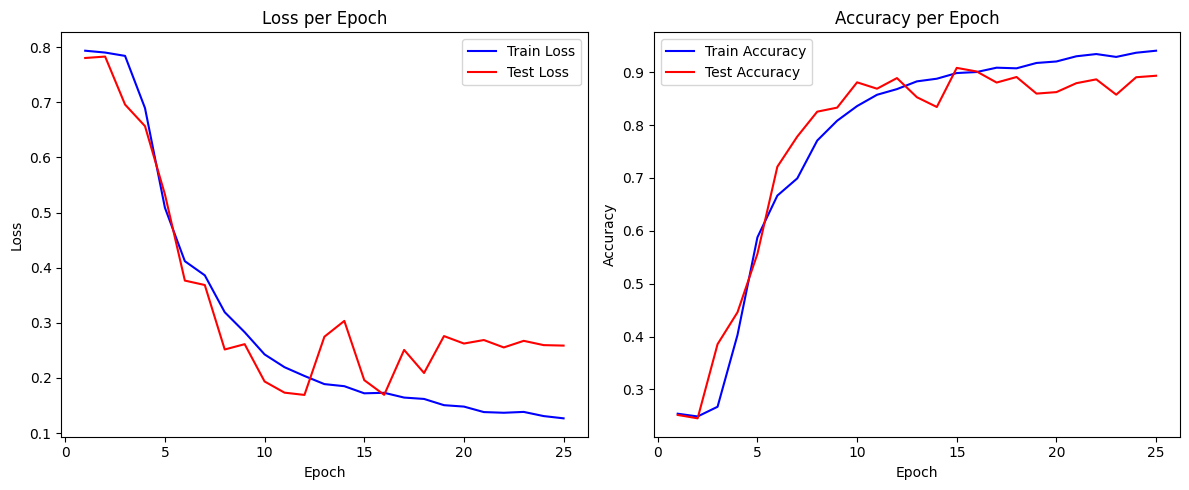


Classification Report:

              precision    recall  f1-score   support

  EOSINOPHIL       0.96      0.86      0.91       623
  LYMPHOCYTE       1.00      1.00      1.00       620
    MONOCYTE       0.96      0.84      0.89       620
  NEUTROPHIL       0.76      0.93      0.84       624

    accuracy                           0.91      2487
   macro avg       0.92      0.91      0.91      2487
weighted avg       0.92      0.91      0.91      2487



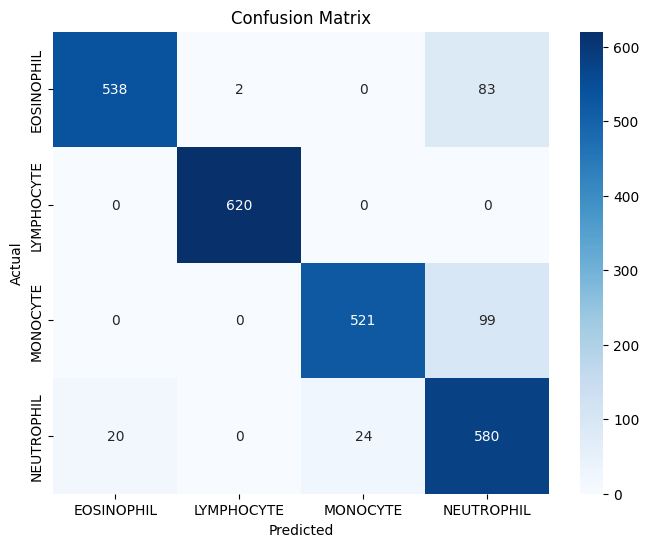

In [20]:
# Train model
train_losses, train_accs, test_losses, test_accs = train_eval_model(
    model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=25
)

# Plot training and test metrics
plot_results(train_losses, train_accs, test_losses, test_accs)

# Load best model and evaluate
load_checkpoint('best_model.pth', model, optimizer)
evaluate_model(model, test_loader)
